# Units check

What happens using different current denisty units?
1. $mA/cm^2$
2. $A/cm^2$

In [25]:
# importing packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from func_RAFA import *
from Thermal_assess import *

from scipy.optimize import curve_fit

from scipy.optimize import fsolve
from sklearn.metrics import r2_score

import seaborn as sns

In [34]:
plt.style.use('classic')
plt.rcParams.update({'font.size': 18, 'font.family': "Times New Roman"})
default_colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [3]:
#%% constants
R=8.31 # [J/mol*K] universal gas constant
F=96500 #[C/mol]  Faraday constant

#%%folders names and loading experiments data

param="Fitting Parameters" #Parameters fodler name
exp="Experiments"

In [6]:
#importing data
df_Ullberg=pd.read_excel(exp+"\\Ullberg exp.xlsx")


In [7]:
df_Ullberg.head()

,J [mA/cm^2],Vcell [V],Temp [°C]
0,122.275204,1.852878,30
1,125.538395,1.858559,30
2,40.151947,1.665312,40
3,56.757135,1.709372,40
4,74.376968,1.740617,40


<AxesSubplot: xlabel='J [mA/cm^2]', ylabel='Vcell [V]'>

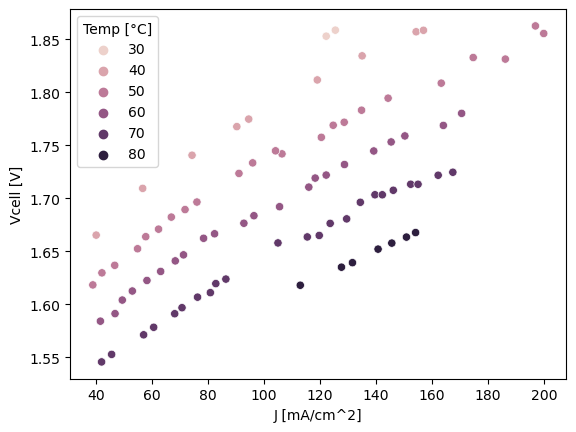

In [5]:
sns.scatterplot(data=df_Ullberg, x="J [mA/cm^2]", y="Vcell [V]",hue="Temp [°C]")

In [10]:
# semi-empirical model


def func_fit1(X, delta_l, alfa, C1,C2):
    j,T = X
    model= AEC_model(T,P_s,w)
    model.wt_to_cOH()
    sigma_l=model.sigma_liquid()    
    v_rev=model.v_rev() #V

    return v_rev+j*(delta_l/(sigma_l*1000))+((R*T)/(alfa*2*F))*(np.log(j)-(C1/T+C2))

1. $C1=-E_a/R$
2. $C2=ln(B)$

In [23]:
# adding a column for Kelving temperature
df_Ullberg["T [K]"]=df_Ullberg["Temp [°C]"]+273

#Random sampling data from dataset
sampling_number=40
rand=df_Ullberg.sample(n=sampling_number,random_state=42) #random state serves to be replicable

# sampling condition(at least data from two diffferent temperarures)
while rand.groupby("T [K]").size().min()<=1 or len(rand["T [K]"].unique())<2:
    rand=df_Ullberg.sample(n=sampling_number)


In [21]:
#Ullberg operation conditions
P_s=7#bar system pressure bar
w=0.3

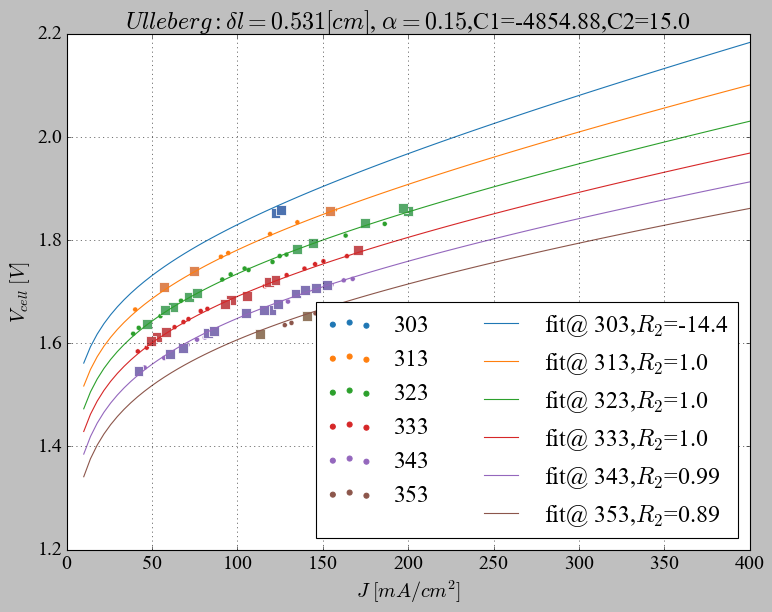

In [36]:
# using mA/cm^2

#find how many working temperatures
T_s=df_Ullberg["T [K]"].unique()


# preparing the data to be used in the fitting function
j=rand.iloc[:,0].to_numpy()
T=rand["T [K]"].to_numpy()
y=rand["Vcell [V]"].to_numpy()

# initial guesses and boundaries (to accelerate the fitting process)
p0=0.70,0.17,-5440,10  #delta_l, alfa, C1,C2
bnds=((0,0.1,-8000,0),(1,0.4,-3000,15))

# curve fitting and extract the values
popt, pcov=curve_fit(func_fit1, (j,T), y, p0,bounds=bnds)

# creating the summary picture
j_new=np.linspace(10,400,100) # current densities in mA/cm^2





plt.figure(figsize=(10,8))
sns.scatterplot(data=df_Ullberg, x="J [mA/cm^2]", y="Vcell [V]",hue="T [K]",palette="tab10")
sns.scatterplot(data=rand, x="J [mA/cm^2]", y="Vcell [V]",hue="T [K]",marker="s",s=80,palette="deep",legend=False)

ax=plt.gca()

for j,l in enumerate(T_s):
    T_new=[l]*len(j_new)
    
    y_fit=[]
    
    for i in range(len(j_new)):        
        y_fit.append(func_fit1((j_new[i],T_new[i]),*popt))
        
    d=df_Ullberg[df_Ullberg["T [K]"]==l]
    
    y_pred=[]
    for jj in d["J [mA/cm^2]"]:
        y_pred.append(func_fit1((jj,l),*popt))
        
    y_real=d["Vcell [V]"]    
    
    s=r2_score(y_real, y_pred)    


     

    ax.plot(j_new,y_fit,label=f"fit@ {l},$R_2$={round(s,2)}",color=default_colors[j])

ax.set_ylim(1.2,2.2)
ax.legend()
ax.set_title(f"$Ulleberg:\\delta l={round(popt[0],3)} [cm]$, $\\alpha={round(popt[1],2)}$,C1={round(popt[2],2)},C2={round(popt[3],2)}")

ax.grid()

ax.legend(loc=0,ncol=2)
ax.set_xlim(0,400)
ax.set_xlabel("$J$ $[mA/cm^2]$")
ax.set_ylabel("$V_{cell}$ $[V]$")
plt.tight_layout()


In [28]:
scale_factor=1/1000 #(conversion factor from mA/cm^2 into A/cm^2)

rand.iloc[:,0].to_numpy()

array([ 53.06242815,  82.86732977,  58.28143483,  74.37696806,
       199.9375219 ,  46.77629496, 170.6282801 , 144.3758018 ,
        56.757135  , 150.9243431 , 174.7591676 , 113.0209427 ,
        49.47851585,  96.47406741,  71.88117492, 105.6291964 ,
        68.18996684,  86.46173839,  92.88665634, 122.2752037 ,
       119.7875743 , 140.7930558 ,  60.68392729, 118.3437464 ,
        42.08443711, 125.5383949 , 152.4404792 , 196.9705603 ,
       123.6922077 , 122.2693724 , 154.3811333 , 134.4579397 ,
        62.42281868, 134.8999517 ,  57.85225171, 146.2278203 ,
       105.0577298 , 115.5307309 ,  76.12402326, 139.683944  ])

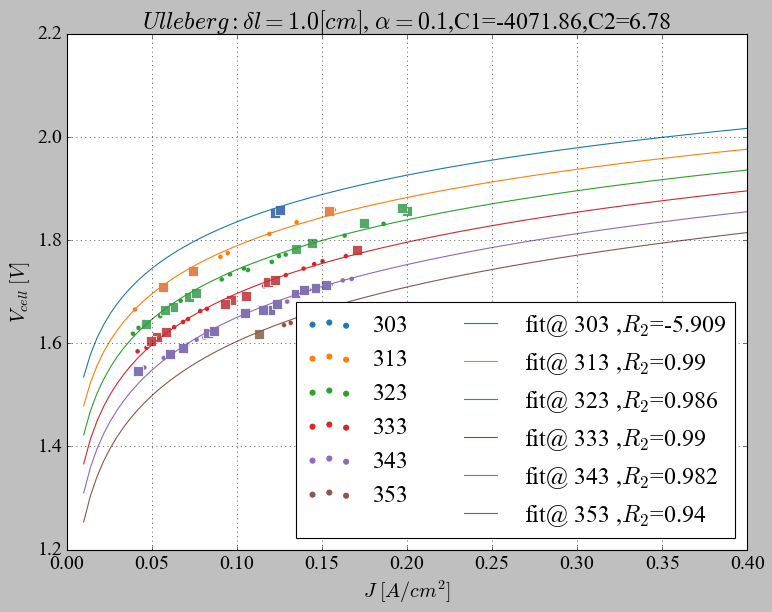

In [41]:
# using A/cm^2, converting current densities of experimetal data (Without changing the MODEL!!!)
scale_factor=1/1000 #(conversion factor from mA/cm^2 into A/cm^2)
df_Ullberg["J [A/cm^2]"]=df_Ullberg["J [mA/cm^2]"]*scale_factor
rand["J [A/cm^2]"]=rand["J [mA/cm^2]"]*scale_factor



#find how many working temperatures
T_s=df_Ullberg["T [K]"].unique()


# preparing the data to be used in the fitting function
j=rand.iloc[:,0].to_numpy()*scale_factor
T=rand["T [K]"].to_numpy()
y=rand["Vcell [V]"].to_numpy()

# initial guesses and boundaries (to accelerate the fitting process)
p0=0.70,0.17,-5440,10  #delta_l, alfa, C1,C2
bnds=((0,0.1,-8000,0),(1,0.4,-3000,15))

# curve fitting and extract the values
popt, pcov=curve_fit(func_fit1, (j,T), y, p0,bounds=bnds)

# creating the summary picture
j_new=np.linspace(10,400,100)*scale_factor # current densities in mA/cm^2





plt.figure(figsize=(10,8))
sns.scatterplot(data=df_Ullberg, x="J [A/cm^2]", y="Vcell [V]",hue="T [K]",palette="tab10")
sns.scatterplot(data=rand, x="J [A/cm^2]", y="Vcell [V]",hue="T [K]",marker="s",s=80,palette="deep",legend=False)

ax=plt.gca()

for j,l in enumerate(T_s):
    T_new=[l]*len(j_new)
    
    y_fit=[]
    
    for i in range(len(j_new)):        
        y_fit.append(func_fit1((j_new[i],T_new[i]),*popt))
        
    d=df_Ullberg[df_Ullberg["T [K]"]==l]
    
    y_pred=[]
    for jj in d["J [A/cm^2]"]:
        y_pred.append(func_fit1((jj,l),*popt))
        
    y_real=d["Vcell [V]"]    
    
    s=r2_score(y_real, y_pred)    


     

    ax.plot(j_new,y_fit,label=f"fit@ {l} ,$R_2$={round(s,3)}",color=default_colors[j])

ax.set_ylim(1.2,2.2)
ax.legend()
ax.set_title(f"$Ulleberg:\\delta l={round(popt[0],3)} [cm]$, $\\alpha={round(popt[1],2)}$,C1={round(popt[2],2)},C2={round(popt[3],2)}")

ax.grid()

ax.legend(loc=0,ncol=2)
ax.set_xlim(0,400*scale_factor)
ax.set_xlabel("$J$ $[A/cm^2]$")
ax.set_ylabel("$V_{cell}$ $[V]$")
plt.tight_layout()